In [1]:
%matplotlib inline

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys
import joblib

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

# Paleta de Analisis

In [3]:
hues = np.array([(hue) for hue, _, _ in np_itten_color_wheel])


In [4]:
sorted_np_itten_color_wheel = pd.DataFrame(np_itten_color_wheel).sort_values(by=0, ascending=False).values

In [5]:
sorted_np_itten_color_wheel[:, 0]*360

array([349., 313., 268., 248., 233., 188., 130.,  70.,  53.,  42.,  32.,
        19.])

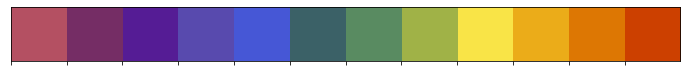

In [6]:
sns.palplot(get_palette(sorted_np_itten_color_wheel))

In [7]:
names = [
    'red', 'red-violet', 'violet', 'blue-violet', 'blue', 'blue-green', 'green', 'yellow-green', 'yellow','yellow-orange','orange', 'red-orange'
]

In [8]:
# a la mala
comparisons = []
for name, hue in zip(names, sorted_np_itten_color_wheel[:, 0]):
    for other_name, other_hue in zip(names, sorted_np_itten_color_wheel[:, 0]):
        if name == other_name:
            continue
        
        angle = hue*360 - other_hue*360
        angle = (angle + 180) % 360 - 180
        
        comparison = str(sorted([name, other_name]))
        comparisons.append((name, other_name, comparison, angle))
        
pd_comparisons = pd.DataFrame(comparisons, columns=['name', 'other_name', 'dominant_colors', 'angle'])
pd_comparisons = pd_comparisons.groupby('dominant_colors').head(1).reset_index()
pd_comparisons['angle'] = np.abs(pd_comparisons['angle'])

In [9]:
# Generacion de cilindro de color

In [10]:
hues = np.array([hue for hue, _, _ in sorted_np_itten_color_wheel])
example_hues = np.array([(hue_step, 0.5, 0.5) for hue_step in hues])

luminances = np.array([0, 0.33, 0.66, 1])
hue_luminance = np.transpose([np.tile(hues, len(luminances)), np.repeat(luminances, len(hues))]).copy()
saturations = np.array([0, 0.33, 0.66, 1])

hls_stack = []
for saturation in saturations:
    hls_array_proto = np.zeros((hue_luminance.shape[0], hue_luminance.shape[1] + 1))
    hls_array_proto[:, :2] = hue_luminance.copy()
    
    hls_array_proto[:, 2] = saturation
    hls_stack.append(hls_array_proto)
    
cube = np.stack(hls_stack).reshape(-1,3)

In [11]:
pd_cube = pd.DataFrame(cube, columns=['hue', 'luminance', 'saturation'])
pd_cube = pd_cube.sort_values(by=['hue','luminance','saturation']).reset_index(drop=True)
pd_cube = pd_cube.reset_index()

final_cube = pd_cube[['hue','luminance','saturation']].values.reshape(12, 4, 4, 3)
cube_palette = final_cube.reshape(-1, 3)
cube_indices = np.array(list(range(len(cube_palette))))

In [12]:
pd_cube['blanco'] = 1*(pd_cube['luminance'] == 1)
pd_cube['negro'] = 1*(pd_cube['luminance'] == 0)
pd_cube['gris'] = 1*(pd_cube['saturation'] == 0)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])

In [13]:
for idx, hue in enumerate(hues):
    pd_cube['hue_%s' % idx] = 1*(pd_cube['hue'] == hue)*(1-pd_cube['blanco'])*(1-pd_cube['negro'])*(1-pd_cube['gris'])

In [14]:
blancos = list(pd_cube[pd_cube['blanco'] == 1]['index'].values)
negros = list(pd_cube[pd_cube['negro'] == 1]['index'].values)
gris = list(pd_cube[pd_cube['gris'] == 1]['index'].values)

In [15]:
final_analysis_array = [
    ('negros', negros, np.array([0, 0, 0]))
    ,('grises', gris, np.array([0, 0.5, 0]))
    ,('blancos', blancos, np.array([0, 0.85, 0]))
] + [
    (
        names[hue_idx],
        list(pd_cube[pd_cube['hue_%s' % hue_idx] == 1]['index'].values), 
        sorted_np_itten_color_wheel[hue_idx]
    )
    for hue_idx in range(len(hues))
]

final_analysis_names = [i[0] for i in final_analysis_array]
final_analysis_palette = np.array([i[2] for i in final_analysis_array])

inverse_map = {}
for name, codes, color in final_analysis_array:
    for code in codes:
        inverse_map[code] = color

In [16]:
pd_cube[pd_cube['negro'] == 1]

,index,hue,luminance,saturation,blanco,negro,gris,hue_0,hue_1,hue_2,hue_3,hue_4,hue_5,hue_6,hue_7,hue_8,hue_9,hue_10,hue_11
0,0,0.052778,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.052778,0.0,0.33,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.052778,0.0,0.66,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.052778,0.0,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
16,16,0.088889,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17,17,0.088889,0.0,0.33,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
18,18,0.088889,0.0,0.66,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
19,19,0.088889,0.0,1.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
32,32,0.116667,0.0,0.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33,33,0.116667,0.0,0.33,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


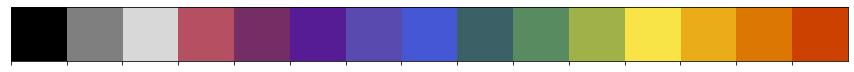

In [17]:
sns.palplot(get_palette(final_analysis_palette))

In [18]:
def quantize_img_twice(img_hls, preprocess=preprocess_img_hls, palette=cube_palette):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(preprocess(img_hls), palette, apply_sin_to_hue=True)
    
    return np.array(list(map(lambda x: inverse_map[x], palette_index_matrix.flatten()))).reshape(shape[0], shape[1], 3)

def get_rgb_quantize_img_twice(img_hls, preprocess=preprocess_img_hls, palette=cube_palette):
    quantized_img = quantize_img_twice(img_hls, preprocess, palette) * (180, 255, 255)
    
    plt.imshow(cv2.cvtColor(np.uint8(quantized_img), cv2.COLOR_HLS2RGB))
    plt.show()

In [19]:
preprocess_img_hls

<function scripts.preprocess_img_hls(img_hls)>

# Carga archivos

In [20]:
cam = cam = glob.glob('../../../../photos/cam/*.jpg')

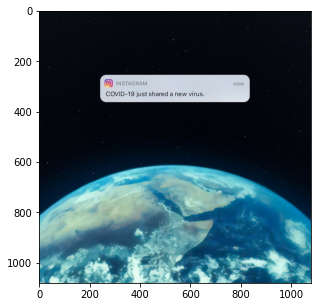

In [21]:
img_idx = 4
#img_idx = 11
#img_idx = 46

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

In [22]:
results = joblib.Parallel(n_jobs=12)(joblib.delayed(get_image_signature)(img_path, analysis_palette=cube_palette, apply_sin_to_hue=True) for img_path in tqdm(cam))

100%|██████████| 1537/1537 [05:08<00:00,  4.99it/s]


In [23]:
signatures = results

In [24]:
pd_signatures = pd.DataFrame(signatures).fillna(0)

In [25]:
for name, indices, _ in final_analysis_array:
    pd_signatures[name] = pd_signatures[indices].sum(axis=1)

In [26]:
pd_discretized_signature = pd_signatures[final_analysis_names[3:]]
pd_discretized_total_signature = pd_signatures[final_analysis_names]

In [27]:
pd_discr_weighted_signatures = pd_discretized_signature.apply(lambda x: x/x.sum(), axis=1).fillna(0)
pd_discr_weighted_total_signatures = pd_discretized_total_signature.apply(lambda x: x/x.sum(), axis=1)

In [28]:
pd_discr_weighted_total_signatures[['blancos','negros','grises']].sum(axis=1).sort_values().tail(200)

86      0.979223
158     0.979230
239     0.979260
1246    0.979678
297     0.979841
          ...   
526     1.000000
34      1.000000
1208    1.000000
1089    1.000000
916     1.000000
Length: 200, dtype: float64

<AxesSubplot:>

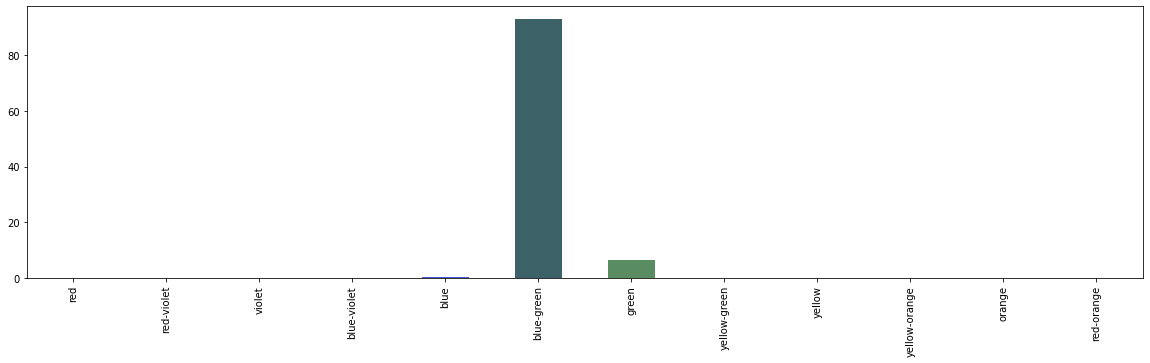

In [29]:
(pd_discr_weighted_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette[3:]))

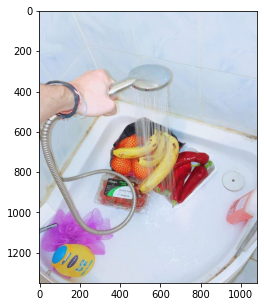

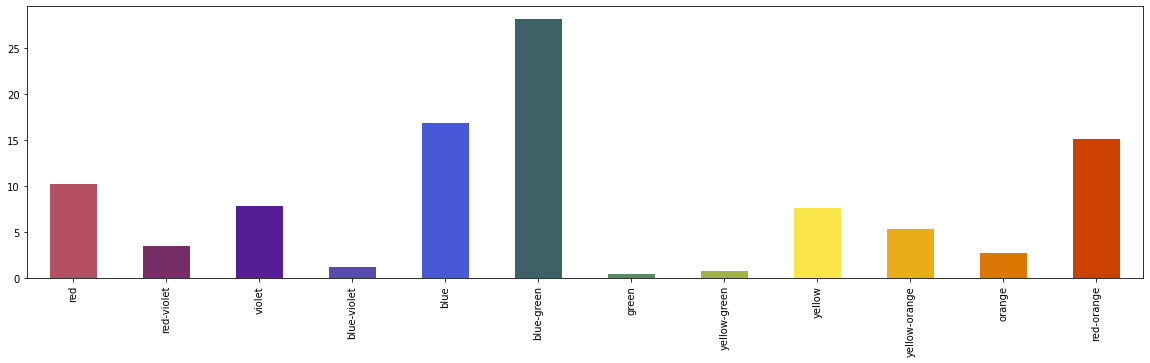

red              10.260331
red-violet        3.512680
violet            7.826968
blue-violet       1.158541
blue             16.911934
blue-green       28.172572
green             0.487908
yellow-green      0.794580
yellow            7.617409
yellow-orange     5.359957
orange            2.721720
red-orange       15.175400
Name: 751, dtype: float64


In [31]:
img_idx = 751
#img_idx = 11
#img_idx = 46

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

(pd_discr_weighted_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette[3:]))
plt.show()
print((pd_discr_weighted_signatures.iloc[img_idx]*100))

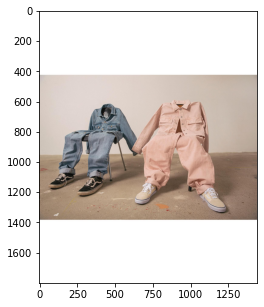

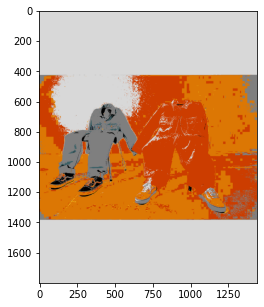

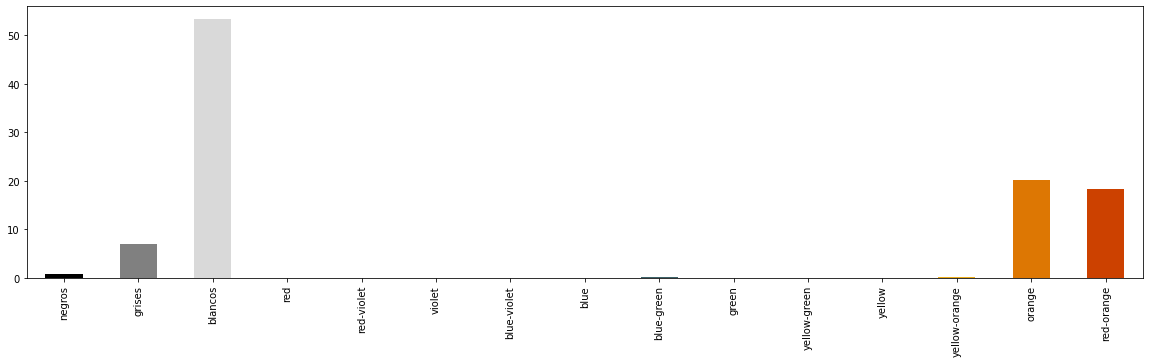

red               0.007346
red-violet        0.000993
violet            0.000000
blue-violet       0.000000
blue              0.030772
blue-green        0.637184
green             0.000099
yellow-green      0.001688
yellow            0.009629
yellow-orange     0.312388
orange           51.962228
red-orange       47.037674
Name: 102, dtype: float64


In [44]:
img_idx = 102
#img_idx = 11
#img_idx = 46

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

get_rgb_quantize_img_twice(get_img(cam[img_idx])[1])
plt.show()

(pd_discr_weighted_total_signatures.iloc[img_idx]*100).plot.bar(color=get_palette(final_analysis_palette))
plt.show()
print((pd_discr_weighted_signatures.iloc[img_idx]*100))

<AxesSubplot:>

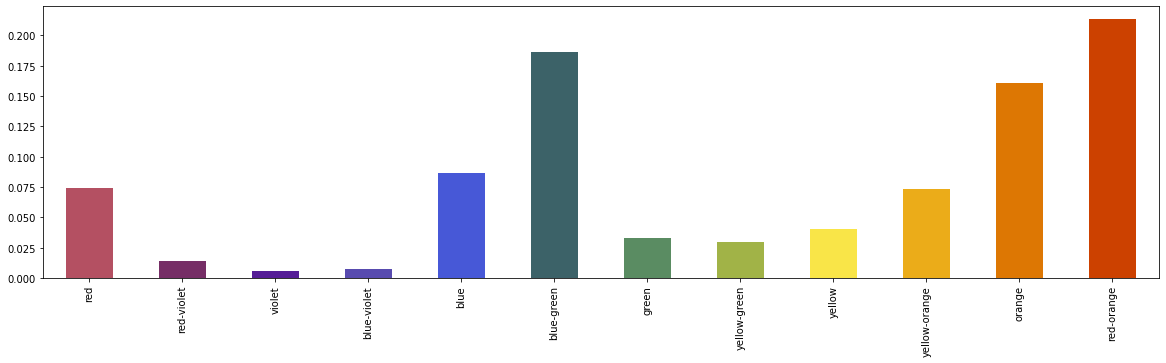

In [33]:
pd_discr_weighted_signatures.mean().plot.bar(color=get_palette(final_analysis_palette[3:]))

<AxesSubplot:>

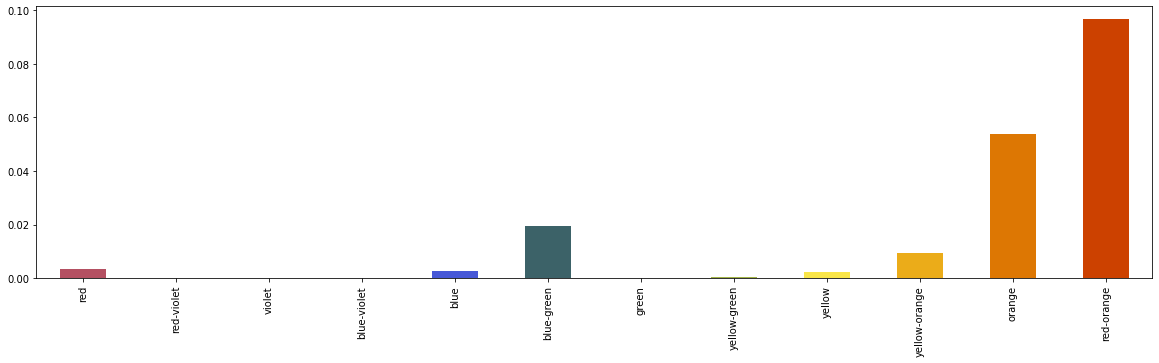

In [34]:
pd_discr_weighted_signatures.median().plot.bar(color=get_palette(final_analysis_palette[3:]))

<AxesSubplot:>

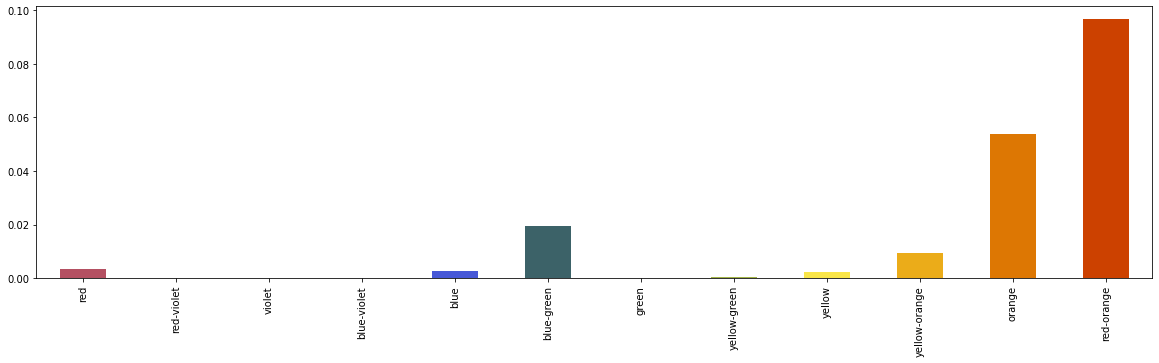

In [35]:
pd_discr_weighted_signatures.median().plot.bar(color=get_palette(final_analysis_palette[3:]))

# Check relaciones

In [36]:
def monochromatic(wheelColors):
    return sum(wheelColors)==1


def complementary(wheelColors):
    for curr in range(12):
        opp = (curr+6) % 12
        if wheelColors[curr]==1 and wheelColors[opp]==1:
            return True
    return False


def splitComplementary(wheelColors):
    for curr in range(12):
        opp_left = (curr+5) % 12
        opp_right = (curr+7) % 12
        if wheelColors[curr]==1 and wheelColors[opp_left]==1 and wheelColors[opp_right]==1:
            return True
    return False


def triad(wheelColors):
    for curr in range(12):
        left = (curr+4) % 12
        right = (curr+8) % 12
        if wheelColors[curr]==1 and wheelColors[left]==1 and wheelColors[right]==1:
            return True
    return False


def square(wheelColors):
    for curr in range(12):
        left = (curr+3) % 12
        right = (curr+9) % 12
        opp = (curr+6) % 12
        if wheelColors[curr]==1 and wheelColors[left]==1 and wheelColors[right]==1 and wheelColors[opp]==1:
            return True
    return False


def rectangular(wheelColors):
    for curr in range(6):
        for width in range(1,3):
            left = (curr+width) % 12
            right = (curr+6+width) % 12
            opp = (curr+6) % 12
            if wheelColors[curr]==1 and wheelColors[left]==1 and wheelColors[right]==1 and wheelColors[opp]==1:
                return True
    return False


def analogous(wheelColors):
    for curr in range(12):
        right = (curr+1) % 12
        if wheelColors[curr]==1 and wheelColors[right]==1:
            return True
    return False

In [37]:
check_relaciones = pd_discr_weighted_signatures.copy()

In [47]:
check_relaciones = pd_discr_weighted_total_signatures.copy()

check_relaciones['monochromatic'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(monochromatic, axis=1)
check_relaciones['analogous'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(analogous, axis=1)
check_relaciones['complementary'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(complementary, axis=1)
check_relaciones['splitComplementary'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(splitComplementary, axis=1)
check_relaciones['triad'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(triad, axis=1)
check_relaciones['square'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(square, axis=1)
check_relaciones['rectangular'] = (1*(pd_discr_weighted_signatures > 0.05)).apply(rectangular, axis=1)


<AxesSubplot:>

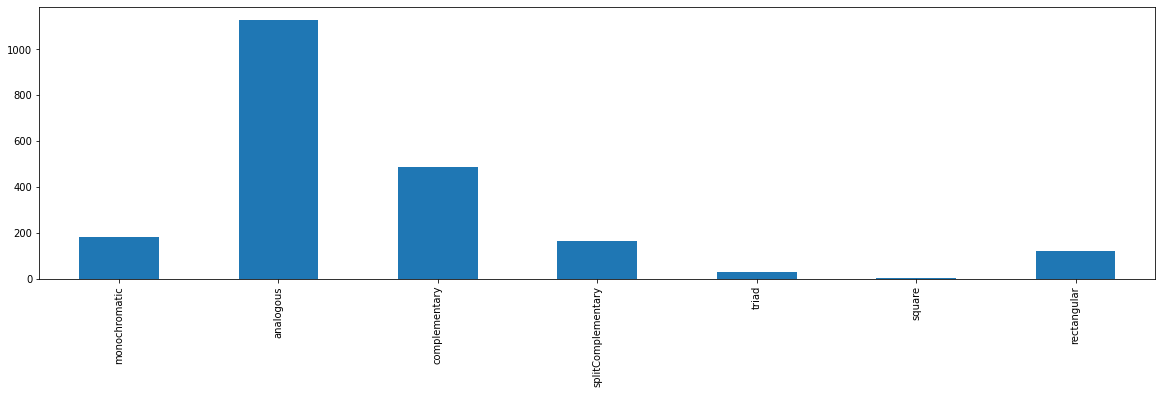

In [48]:
check_relaciones[['monochromatic','analogous','complementary','splitComplementary','triad','square','rectangular']].sum().plot.bar()

In [49]:
check_relaciones[check_relaciones['square'] == 1]

,negros,grises,blancos,red,red-violet,violet,blue-violet,blue,blue-green,green,...,yellow-orange,orange,red-orange,monochromatic,analogous,complementary,splitComplementary,triad,square,rectangular
751,0.002472,0.114026,0.561447,0.033044,0.011313,0.025207,0.003731,0.054466,0.090731,0.001571,...,0.017262,0.008765,0.048873,False,True,True,True,True,True,False
1093,0.027408,0.148114,0.311252,0.061151,0.033945,0.035202,0.003845,0.056478,0.041256,0.011730,...,0.050476,0.029998,0.136564,False,True,True,True,True,True,True


In [51]:
check_relaciones['file_name'] = cam

In [53]:
check_relaciones.to_csv('salida_colores_itten.csv')

In [46]:
pd_discretized_total_signature.merge(check_relaciones[['monochromatic','analogous','']])

,negros,grises,blancos,red,red-violet,violet,blue-violet,blue,blue-green,green,yellow-green,yellow,yellow-orange,orange,red-orange
0,12664.0,27493.0,32070.0,1983.0,956.0,134.0,132.0,2765.0,2521.0,0.0,21.0,8029.0,2029825.0,454064.0,19343.0
1,1096313.0,974603.0,21444.0,36.0,1.0,8.0,43.0,7683.0,16192.0,8.0,9.0,165.0,1278.0,33515.0,5802.0
2,38986.0,708189.0,13313.0,7062.0,9.0,4.0,19.0,27675.0,488179.0,0.0,0.0,18.0,921.0,20013.0,153612.0
3,14017.0,836289.0,1814.0,2.0,0.0,0.0,41.0,144.0,0.0,0.0,39.0,1027.0,98422.0,107432.0,1043.0
4,666153.0,13365.0,67722.0,195.0,263.0,83.0,45.0,2209.0,389170.0,26939.0,3.0,4.0,43.0,83.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,108255.0,9554.0,1955791.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533,251491.0,238056.0,505445.0,30343.0,2101.0,272.0,26334.0,771.0,4840.0,7.0,1361.0,259.0,504.0,46975.0,57641.0
1534,148331.0,15544.0,972453.0,0.0,0.0,0.0,0.0,0.0,0.0,29628.0,444.0,0.0,0.0,0.0,0.0
1535,7965.0,171312.0,562796.0,356.0,0.0,0.0,0.0,0.0,0.0,0.0,686.0,9533.0,70141.0,81464.0,496289.0


# Colores dominantes

In [193]:
pd_discr_weighted_signatures_dom = pd_discr_weighted_signatures.copy()
pd_discr_weighted_signatures_dom['dominant_colors'] = pd_discr_weighted_signatures_dom.apply(lambda x: str(sorted(list(x.sort_values(ascending=False)[:2].index))), axis=1)

In [183]:
new_df = pd_discr_weighted_signatures_dom['dominant_colors'].value_counts().to_frame().reset_index().rename(columns={'index': 'dominant_colors', 'dominant_colors': 'count'})

<AxesSubplot:>

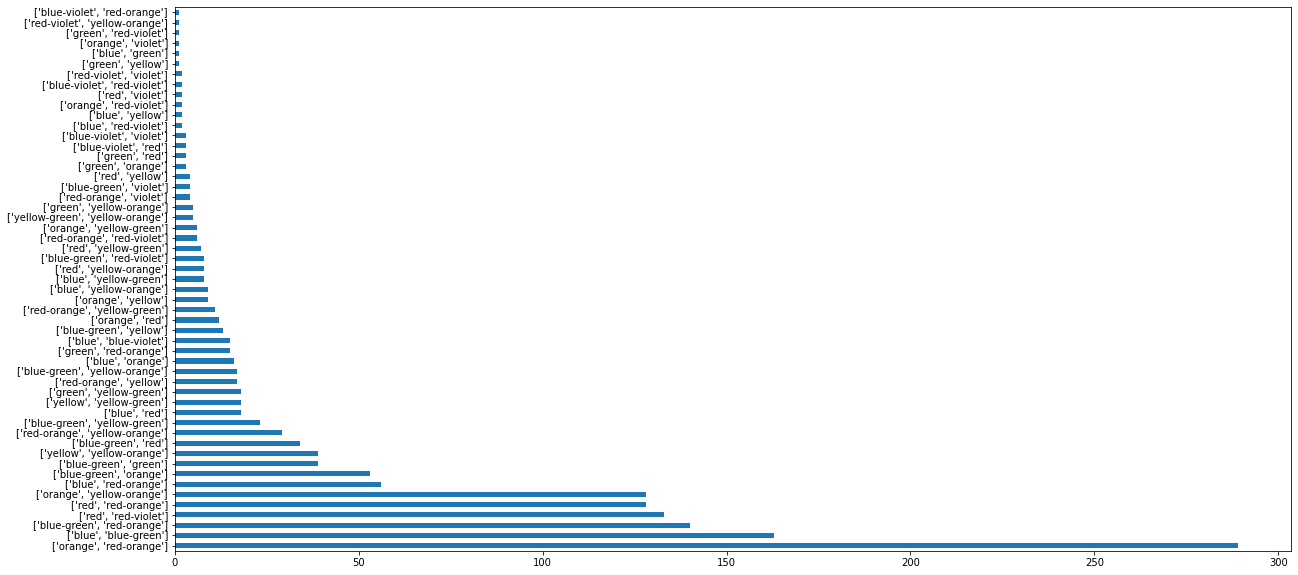

In [179]:
plt.figure(figsize=(20,10))
new_df['dominant_colors'].plot.barh()

In [186]:
new_df = new_df.merge(pd_comparisons[['dominant_colors','angle']], on='dominant_colors')

In [189]:
pd.cut(new_df['angle'], bins=[0, 15, 30, 60, 120, 150, 180]).value_counts()

(60, 120]     18
(30, 60]      10
(150, 180]     8
(120, 150]     7
(15, 30]       6
(0, 15]        4
Name: angle, dtype: int64

In [54]:
pd.cut()

,index,name,other_name,dominant_colors,angle
0,0,red,red-violet,"['red', 'red-violet']",36.0
1,1,red,violet,"['red', 'violet']",81.0
2,2,red,blue-violet,"['blue-violet', 'red']",101.0
3,3,red,blue,"['blue', 'red']",116.0
4,4,red,blue-green,"['blue-green', 'red']",161.0
...,...,...,...,...,...
61,97,yellow,orange,"['orange', 'yellow']",21.0
62,98,yellow,red-orange,"['red-orange', 'yellow']",34.0
63,108,yellow-orange,orange,"['orange', 'yellow-orange']",10.0
64,109,yellow-orange,red-orange,"['red-orange', 'yellow-orange']",23.0


In [194]:
pd_discr_weighted_signatures_dom = pd_discr_weighted_signatures_dom.merge(pd_comparisons[['dominant_colors','angle']], on='dominant_colors')

<AxesSubplot:>

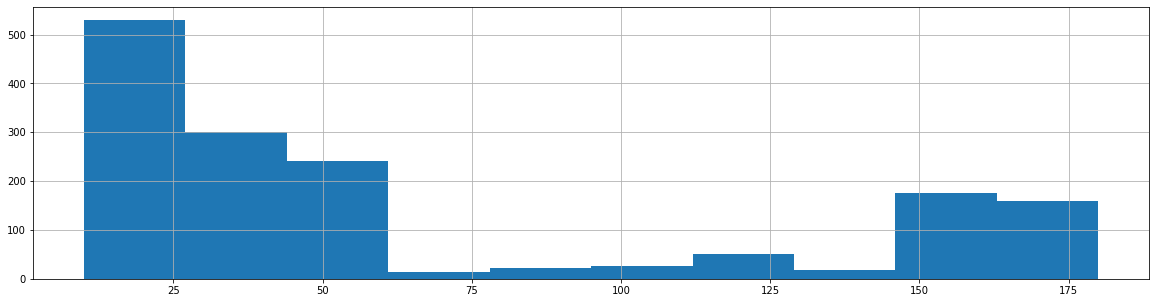

In [195]:
pd_discr_weighted_signatures_dom['angle'].hist()

In [199]:
pd.cut(pd_discr_weighted_signatures_dom['angle'], bins=[0, 15, 30, 60, 90, 120, 150, 180]).value_counts().sort_index()

(0, 15]       471
(15, 30]      192
(30, 60]      409
(60, 90]       36
(90, 120]      67
(120, 150]     99
(150, 180]    263
Name: angle, dtype: int64

,red,red-violet,violet,blue-violet,blue,blue-green,green,yellow-green,yellow,yellow-orange,orange,red-orange
0,0.000787,0.000379,0.000053,0.000052,0.001097,0.001000,0.000000,0.000008,0.003186,0.805559,0.180200,0.007676
1,0.000556,0.000015,0.000124,0.000664,0.118675,0.250108,0.000124,0.000139,0.002549,0.019741,0.517686,0.089620
2,0.010125,0.000013,0.000006,0.000027,0.039677,0.699886,0.000000,0.000000,0.000026,0.001320,0.028692,0.220228
3,0.000010,0.000000,0.000000,0.000197,0.000692,0.000000,0.000000,0.000187,0.004934,0.472842,0.516128,0.005011
4,0.000465,0.000627,0.000198,0.000107,0.005270,0.928452,0.064269,0.000007,0.000010,0.000103,0.000198,0.000293
...,...,...,...,...,...,...,...,...,...,...,...,...
1532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1533,0.177022,0.012257,0.001587,0.153633,0.004498,0.028237,0.000041,0.007940,0.001511,0.002940,0.274054,0.336280
1534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.985235,0.014765,0.000000,0.000000,0.000000,0.000000
1535,0.000541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001042,0.014478,0.106521,0.123717,0.753701


In [162]:
1*(pd_discr_weighted_signatures > 0.15)

,red,red-violet,violet,blue-violet,blue,blue-green,green,yellow-green,yellow,yellow-orange,orange,red-orange
0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1532,0,0,0,0,0,0,0,0,0,0,0,0
1533,1,0,0,1,0,0,0,0,0,0,1,1
1534,0,0,0,0,0,0,1,0,0,0,0,0
1535,0,0,0,0,0,0,0,0,0,0,0,1


In [172]:
(1*(pd_discr_weighted_signatures > 0.15)).to_csv('output_itten_colores_15.csv', index=False)

# Clustering

In [65]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

In [164]:
tfidf_transformed = TfidfTransformer().fit_transform(pd_discr_weighted_signatures)

In [165]:
pd_discr_weighted_total_signatures_analysis = pd_discr_weighted_total_signatures.copy()

In [183]:
pd_discr_weighted_total_signatures_analysis['cluster'] = KMeans(n_clusters=20).fit_predict(tfidf_transformed)

In [184]:
pd_discr_weighted_total_signatures_analysis.groupby('cluster').size()

cluster
0      34
1     124
2      58
3     113
4      66
5     114
6     250
7      54
8      92
9      36
10     53
11     49
12    165
13     24
14     52
15     76
16     56
17     24
18     79
19     18
dtype: int64

In [194]:
pd_discr_weighted_total_signatures_analysis[pd_discr_weighted_total_signatures_analysis['cluster'] == 14].index

Int64Index([  31,   62,   74,   85,  131,  158,  180,  187,  208,  266,  271,
             303,  345,  348,  432,  464,  493,  548,  570,  625,  665,  666,
             694,  709,  728,  734,  735,  747,  751,  819,  839,  848,  858,
             912,  954,  966,  979, 1009, 1068, 1097, 1122, 1139, 1155, 1172,
            1202, 1267, 1392, 1446, 1464, 1476, 1512, 1526],
           dtype='int64')

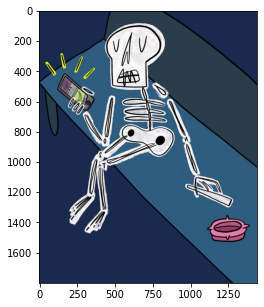

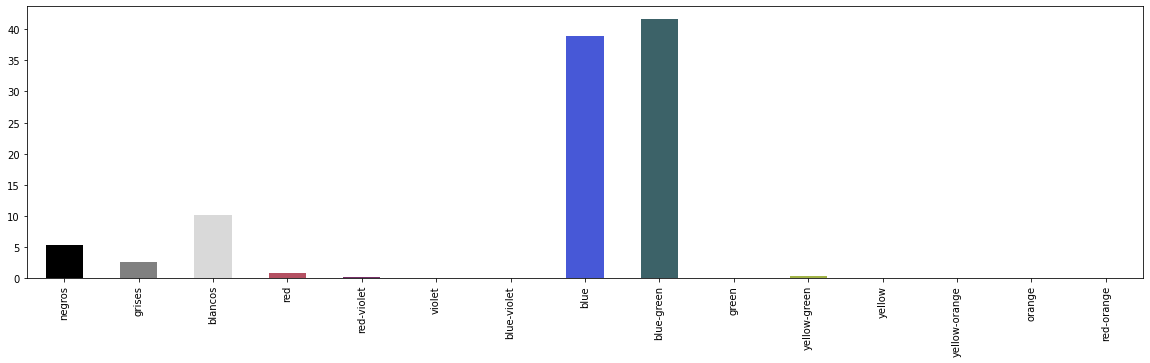

negros            5.394560
grises            2.570679
blancos          10.128819
red               0.853279
red-violet        0.099691
violet            0.004244
blue-violet       0.000617
blue             38.877508
blue-green       41.627199
green             0.022724
yellow-green      0.394560
yellow            0.025887
yellow-orange     0.000039
orange            0.000000
red-orange        0.000193
Name: 1512, dtype: float64


In [201]:
img_idx = 1512

plt.imshow(get_img(cam[img_idx])[0])
plt.show()

(pd_discr_weighted_total_signatures_analysis.iloc[img_idx, :-1]*100).plot.bar(color=get_palette(final_analysis_palette))
plt.show()
print((pd_discr_weighted_total_signatures_analysis.iloc[img_idx, :-1]*100))